In [2]:
import parmed as pmd
import numpy as np
import os
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
from adjustText import adjust_text
import plotting

# Dihedral parameter comparison.

Let's iterate through the structure and look at the parameters, one-by-one. This seems to be the only reliable way to compare apples with apples.

First, find the unique set of four atoms, by atom name, in a single alpha-cyclodextrin residue. Then we'll look at the dihedrals applied to these 4 atom sets. Thankfully, when we query ParmEd for a mask of four atoms, ParmEd looks for the atoms in either ordering (e.g., `a-b-c-d` and `d-c-b-a`), which are the same dihedral, but may be listed separately.

In [76]:
smirnoff_prmtop = pmd.load_file("systems/a-bam-p/smirnoff/a000/hg.prmtop")

bgbg_prmtop = pmd.load_file("systems/a-bam-p/bgbg-tip3p/hg.topo")

bg2bg2_prmtop = pmd.load_file("systems/a-bam-p/bg2bg2-tip3p/vac.topo")


In [77]:
def find_dihedrals(structure, residue=5):
    df = pd.DataFrame()
    for dihedral in structure[f":{residue}"].dihedrals:
        df = df.append(
            pd.DataFrame(
                {
                    "atom1": dihedral.atom1.name,
                    "atom2": dihedral.atom2.name,
                    "atom3": dihedral.atom3.name,
                    "atom4": dihedral.atom4.name,
                },
                index=[0],
            ),
            ignore_index=True,
        )
    return df

In [78]:
bgbg_prmtop_dihedrals = find_dihedrals(bgbg_prmtop)
bg2bg2_prmtop_dihedrals = find_dihedrals(bg2bg2_prmtop)
smirnoff_prmtop_dihedrals = find_dihedrals(smirnoff_prmtop)

These are just labeled by *atom name* so it is safe to drop duplicates by only keeping the unique rows.

In [79]:
bgbg_prmtop_dihedrals.drop_duplicates(inplace=True)
bg2bg2_prmtop_dihedrals.drop_duplicates(inplace=True)
smirnoff_prmtop_dihedrals.drop_duplicates(inplace=True)

In [80]:
assert len(bgbg_prmtop_dihedrals) == len(smirnoff_prmtop_dihedrals)
assert len(bgbg_prmtop_dihedrals) == len(bg2bg2_prmtop_dihedrals)

In [81]:
print(f"There are {len(bgbg_prmtop_dihedrals)} sets of four atoms in the structure.")

There are 54 sets of four atoms in the structure.


In [82]:
bgbg_prmtop_dihedrals.sort_values(by=["atom1", "atom2", "atom3", "atom4"]).head()

,atom1,atom2,atom3,atom4
26,C1,C2,C3,C4
81,C1,C2,C3,H3
25,C1,C2,C3,O3
79,C1,C2,O2,HO2
29,C1,O5,C5,C4


I think there are 54 unique dihedrals by name in a single `:MGO` residue and both GAFF v1.7 and SMIRNOFF99Frosst agree on the names. A little tricky to test for strict equality in the DataFrame because everything is a string, but I'm feeling pretty confident that this is correct.

Next, let's loop through each row, and print the dihedral in GAFF v1.7 and SMIRNOFF99Frosst.

In [83]:
def parse_parmed_output(printDihedrals_string):
    df = pd.DataFrame()
    lines = printDihedrals_string.split("\n")
    for line in lines[1:-1]:
        df = df.append(
            pd.DataFrame(
                {
                    "atom1": "".join(line[10:15]),
                    "atom1 serial": int("".join(line[5:10])),
                    "atom2": "".join(line[30:35]),
                    "atom2 serial": int("".join(line[25:30])),
                    "atom3": "".join(line[52:57]),
                    "atom3 serial": int("".join(line[47:52])),
                    "atom4": "".join(line[72:77]),
                    "atom4 serial": int("".join(line[67:72])),
                    "height": float("".join(line[89:95])),
                    "periodicity": float("".join(line[100:105])),
                    "phase": float("".join(line[111:116])),
                    "EEL scale": float("".join(line[122:128])),
                    "VDW scale": float("".join(line[133:138])),               },
                index=[0],
            ),
            ignore_index=True,
        )
    return df

# End setup

In [84]:
def compare_df(df_one, df_two):
    for (_, row_one), (_, row_two) in zip(df_one.iterrows(), df_two.iterrows()):

        assert row_one.atom1 == row_two.atom1
        assert row_one.atom2 == row_two.atom2
        assert row_one.atom3 == row_two.atom3
        assert row_one.atom4 == row_two.atom4
#         assert row_one.periodicity == row_two.periodicity
#         assert row_one.phase == row_two.phase

        if np.abs(row_one["height"] - row_two["height"]) > 0.01:
            print("Disparity in barrier height.")
            atoms = (
                row_one["atom1"]
                + "-"
                + row_one["atom2"]
                + "-"
                + row_one["atom3"]
                + "-"
                + row_one["atom4"]
            )
            print(f"Look at {atoms}")

        if row_one["periodicity"] != row_two["periodicity"]:
            print("Disparity in periodicity.")
            atoms = (
                row_one["atom1"]
                + "-"
                + row_one["atom2"]
                + "-"
                + row_one["atom3"]
                + "-"
                + row_one["atom4"]
            )
            print(f"Look at {atoms}")

        if row_one["phase"] != row_two["phase"]:
            print("Disparity in phase.")
            atoms = (
                row_one["atom1"]
                + "-"
                + row_one["atom2"]
                + "-"
                + row_one["atom3"]
                + "-"
                + row_one["atom4"]
            )
            print(f"Look at {atoms}")

        # Can optionally check for scaling here, but I do it separately down below.

        df = pd.DataFrame(
            {
                "atom1": row_one.atom1,
                "atom2": row_one.atom2,
                "atom3": row_one.atom3,
                "atom4": row_one.atom4,
                "periodicity": row_one.periodicity,
                "phase": row_one.phase,
                "x_k": row_one.height,
                "y_k": row_two.height,
            },
            index = [0]
        )
        return df

In [85]:
combined_df = pd.DataFrame()

for index, row in bgbg_prmtop_dihedrals.sort_values(by=["atom1", "atom2", "atom3", "atom4"]).iterrows():
    # Create an atom mask from the four atoms.
    mask = f"@{row['atom1']} @{row['atom2']} @{row['atom3']} @{row['atom4']}"
    bgbg_string = str(pmd.tools.actions.printDihedrals(bgbg_prmtop, mask))
    # Turn the "printDihedrals" output from ParmEd into a DataFrame
    bgbg_df = parse_parmed_output(bgbg_string)
    
    smirnoff_string = str(pmd.tools.actions.printDihedrals(smirnoff_prmtop, mask))
    smirnoff_df = parse_parmed_output(smirnoff_string)
    
    # Check whether these four atoms have more entry one in FF than the other
    if not len(bgbg_df) == len(smirnoff_df):
        print(f"GAFF v1.7 has {len(bgbg_df)} and SMIRNOFF99Frosst has {len(smirnoff_df)}")
        print(f"{row['atom1']}-{row['atom2']}-{row['atom3']}-{row['atom4']}")
        
    # Sort the DataFrames and then compare that each row has the same barrier height, periodicity, and phase
    row_df = compare_df(bgbg_df.sort_values(by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]), 
               smirnoff_df.sort_values(by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]))
    
    combined_df = combined_df.append(row_df)


GAFF v1.7 has 21 and SMIRNOFF99Frosst has 19
C1-C2-C3-C4
GAFF v1.7 has 6 and SMIRNOFF99Frosst has 12
H1-C1-C2-O2
Disparity in barrier height.
Look at   H1 -   C1-  C2 -   O2
Disparity in periodicity.
Look at   H1 -   C1-  C2 -   O2


In [86]:
pmd.tools.actions.printDihedrals(smirnoff_prmtop, "@H1 @C1 @C2 @O2")

               Atom 1               Atom 2               Atom 3               Atom 4     Height  Periodic.      Phase  EEL Scale  VDW Scale
        2   H1 (   2)        1   C1 (   1)        4   C2 (   4)        6   O2 (   6)     0.0000     3.0000     0.0000     1.2000     2.0000
M       2   H1 (   2)        1   C1 (   1)        4   C2 (   4)        6   O2 (   6)     0.2500     1.0000     0.0000     1.0000     1.0000
       23   H1 (  23)       22   C1 (  22)       25   C2 (  25)       27   O2 (  27)     0.0000     3.0000     0.0000     1.2000     2.0000
M      23   H1 (  23)       22   C1 (  22)       25   C2 (  25)       27   O2 (  27)     0.2500     1.0000     0.0000     1.0000     1.0000
       44   H1 (  44)       43   C1 (  43)       46   C2 (  46)       48   O2 (  48)     0.0000     3.0000     0.0000     1.2000     2.0000
M      44   H1 (  44)       43   C1 (  43)       46   C2 (  46)       48   O2 (  48)     0.2500     1.0000     0.0000     1.0000     1.0000
       65   H1 (  65

In [88]:
pmd.tools.actions.printDihedrals(bgbg_prmtop, "@H1 @C1 @C2 @O2")

               Atom 1               Atom 2               Atom 3               Atom 4     Height  Periodic.      Phase  EEL Scale  VDW Scale
        2   H1 (  h2)        1   C1 (  c3)        4   C2 (  c3)        6   O2 (  oh)     0.1556     3.0000     0.0000     1.2000     2.0000
       23   H1 (  h2)       22   C1 (  c3)       25   C2 (  c3)       27   O2 (  oh)     0.1556     3.0000     0.0000     1.2000     2.0000
       44   H1 (  h2)       43   C1 (  c3)       46   C2 (  c3)       48   O2 (  oh)     0.1556     3.0000     0.0000     1.2000     2.0000
       65   H1 (  h2)       64   C1 (  c3)       67   C2 (  c3)       69   O2 (  oh)     0.1556     3.0000     0.0000     1.2000     2.0000
       86   H1 (  h2)       85   C1 (  c3)       88   C2 (  c3)       90   O2 (  oh)     0.1556     3.0000     0.0000     1.2000     2.0000
      107   H1 (  h2)      106   C1 (  c3)      109   C2 (  c3)      111   O2 (  oh)     0.1556     3.0000     0.0000     1.2000     2.0000

We also need to check the torsions that go between two residues.

In [89]:
def parse_parmed_output_with_marker(printDihedrals_string):
    df = pd.DataFrame()
    lines = printDihedrals_string.split("\n")
    for line in lines[1:-1]:
        df = df.append(
            pd.DataFrame(
                {
                    "marker": line[0],
                    "atom1": "".join(line[10:15]),
                    "atom1 serial": int("".join(line[5:10])),
                    "atom2": "".join(line[30:35]),
                    "atom2 serial": int("".join(line[25:30])),
                    "atom3": "".join(line[52:57]),
                    "atom3 serial": int("".join(line[47:52])),
                    "atom4": "".join(line[72:77]),
                    "atom4 serial": int("".join(line[67:72])),
                    "height": float("".join(line[89:95])),
                    "periodicity": float("".join(line[100:105])),
                    "phase": float("".join(line[111:116])),
                    "EEL scale": float("".join(line[122:128])),
                    "VDW scale": float("".join(line[133:138])),               },
                index=[0],
            ),
            ignore_index=True,
        )
    return df

In [ ]:
for mask in interresidue_masks:
    
    gaff_string = str(pmd.tools.actions.printDihedrals(gaff_two_residue, mask))
    gaff_df = parse_parmed_output_with_marker(gaff_string)
    smirnoff_string = str(pmd.tools.actions.printDihedrals(smirnoff_two_residue, mask))
    smirnoff_df = parse_parmed_output_with_marker(smirnoff_string)
    
    if not len(gaff_df) == len(smirnoff_df):
        print(f"GAFF v1.7 has {len(gaff_df)} and SMIRNOFF99Frosst has {len(smirnoff_df)}")
        print(f"{row['atom1']}-{row['atom2']}-{row['atom3']}-{row['atom4']}")
        
    compare_df(gaff_df.sort_values(by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]), 
               smirnoff_df.sort_values(by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]))

    compare_df_for_scaling(gaff_df.sort_values(by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]), 
           smirnoff_df.sort_values(by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]))


In [ ]:
smirnoff_df

## Putting it all together

In [90]:
def compare_df(df_one, df_two):
    for (_, row_one), (_, row_two) in zip(df_one.iterrows(), df_two.iterrows()):

        assert row_one.atom1 == row_two.atom1
        assert row_one.atom2 == row_two.atom2
        assert row_one.atom3 == row_two.atom3
        assert row_one.atom4 == row_two.atom4

        if np.abs(row_one["height"] - row_two["height"]) > 0.01:
            print("Disparity in barrier height.")
            atoms = (
                row_one["atom1"]
                + "-"
                + row_one["atom2"]
                + "-"
                + row_one["atom3"]
                + "-"
                + row_one["atom4"]
            )
            print(f"Look at {atoms}")

        if row_one["periodicity"] != row_two["periodicity"]:
            print("Disparity in periodicity.")
            atoms = (
                row_one["atom1"]
                + "-"
                + row_one["atom2"]
                + "-"
                + row_one["atom3"]
                + "-"
                + row_one["atom4"]
            )
            print(f"Look at {atoms}")

        if row_one["phase"] != row_two["phase"]:
            print("Disparity in phase.")
            atoms = (
                row_one["atom1"]
                + "-"
                + row_one["atom2"]
                + "-"
                + row_one["atom3"]
                + "-"
                + row_one["atom4"]
            )
            print(f"Look at {atoms}")

        # Can optionally check for scaling here, but I do it separately down below.

        df = pd.DataFrame(
            {
                "atom1": row_one.atom1,
                "atom2": row_one.atom2,
                "atom3": row_one.atom3,
                "atom4": row_one.atom4,
                "periodicity": row_one.periodicity,
                "phase": row_one.phase,
                "x_k": row_one.height,
                "y_k": row_two.height,
            },
            index = [0]
        )
        return df

In [ ]:
def compare_dihedrals(prmtop_one, prmtop_two, residue=5):
    combined_df = pd.DataFrame()

    df_one = find_dihedrals(prmtop_one)
    df_two = find_dihedrals(prmtop_two)

    df_one.drop_duplicates(inplace=True)
    df_two.drop_duplicates(inplace=True)

    assert len(df_one) == len(df_two)

    for index, row in df_one.sort_values(
        by=["atom1", "atom2", "atom3", "atom4"]
    ).iterrows():
        # Create an atom mask from the four atoms.
        mask = f":{residue}@{row['atom1']} :{residue}@{row['atom2']} :{residue}@{row['atom3']} :{residue}@{row['atom4']}"
        mask_one_df, mask_two_df = compare_mask(mask, prmtop_one, prmtop_two)

        # Sort the DataFrames and then compare that each row has the same barrier height, periodicity, and phase
        row_df = compare_df(
            mask_one_df.sort_values(
                by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]
            ),
            mask_two_df.sort_values(
                by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]
            ),
        )

        combined_df = combined_df.append(row_df)
        
    interresidue_masks = [
    ":5@C2 :5@C1 :5@O1 :6@C4",
    ":5@O5 :5@C1 :5@O1 :6@C4",
    ":5@H1 :5@C1 :5@O1 :6@C4",
    ":5@C1 :5@O1 :6@C4 :6@H4",
    ":5@C1 :5@O1 :6@C4 :6@C3",
    ":5@C1 :5@O1 :6@C4 :6@C5",
    ":5@O1 :6@C4 :6@C3 :6@H3",
    ":5@O1 :6@C4 :6@C3 :6@O3",
    ":5@O1 :6@C4 :6@C3 :6@C2",
    ":5@O1 :6@C4 :6@C5 :6@H5",
    ":5@O1 :6@C4 :6@C5 :6@O5",
    ":5@O1 :6@C4 :6@C5 :6@C6",
    ]
    for mask in interresidue_masks:
        combined_df = combined_df.append(compare_interresidue(mask, prmtop_one, prmtop_two))


    return combined_df

In [ ]:
def compare_mask(mask, prmtop_one, prmtop_two):
    one_string = str(pmd.tools.actions.printDihedrals(prmtop_one, mask))
    mask_one_df = parse_parmed_output(one_string)

    two_string = str(pmd.tools.actions.printDihedrals(prmtop_two, mask))
    mask_two_df = parse_parmed_output(two_string)

    # Check whether these four atoms have more entry one in FF than the other
    if not len(mask_one_df) == len(mask_two_df):
        print(f"`df_one` has {len(mask_one_df)} and `df_two` has {len(mask_two_df)}")
        print(f"{mask_one_df['atom1'][0]}-{mask_one_df['atom2'][0]}-{mask_one_df['atom3'][0]}-{mask_one_df['atom4'][0]}")

    return mask_one_df, mask_two_df


In [ ]:
def compare_interresidue(mask, prmtop_one, prmtop_two):
    mask_one_df, mask_two_df = compare_mask(mask, prmtop_one, prmtop_two)
    row_df = compare_df(
        mask_one_df.sort_values(
            by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]
        ),
        mask_two_df.sort_values(
            by=["atom1", "atom2", "atom3", "atom4", "periodicity", "phase"]
        ),
    )
    return row_df

In [30]:
bgbg_smirnoff = compare_dihedrals(bgbg_prmtop, smirnoff_prmtop)

`df_one` has 1 and `df_two` has 2
  H1 -   C1-  C2 -   O2
Disparity in barrier height.
Look at   H1 -   C1-  C2 -   O2
Disparity in periodicity.
Look at   H1 -   C1-  C2 -   O2


In [31]:
pmd.tools.actions.printDihedrals(bgbg_prmtop, ":5@H1 :5@C1 :5@C2 :5@O2")

               Atom 1               Atom 2               Atom 3               Atom 4     Height  Periodic.      Phase  EEL Scale  VDW Scale
       86   H1 (  h2)       85   C1 (  c3)       88   C2 (  c3)       90   O2 (  oh)     0.1556     3.0000     0.0000     1.2000     2.0000

In [32]:
pmd.tools.actions.printDihedrals(smirnoff_prmtop, ":5@H1 :5@C1 :5@C2 :5@O2")

               Atom 1               Atom 2               Atom 3               Atom 4     Height  Periodic.      Phase  EEL Scale  VDW Scale
       86   H1 (  86)       85   C1 (  85)       88   C2 (  88)       90   O2 (  90)     0.0000     3.0000     0.0000     1.2000     2.0000
M      86   H1 (  86)       85   C1 (  85)       88   C2 (  88)       90   O2 (  90)     0.2500     1.0000     0.0000     1.0000     1.0000

In [33]:
bg2bg2_smirnoff = compare_dihedrals(bg2bg2_prmtop, smirnoff_prmtop)

Disparity in barrier height.
Look at   C1 -   C2-  C3 -   C4
Disparity in barrier height.
Look at   C1 -   C2-  C3 -   O3
`df_one` has 1 and `df_two` has 2
  C1 -   C2-  O2 -  HO2
Disparity in barrier height.
Look at   C1 -   C2-  O2 -  HO2
Disparity in periodicity.
Look at   C1 -   C2-  O2 -  HO2
`df_one` has 3 and `df_two` has 2
  C1 -   O5-  C5 -   C4
Disparity in barrier height.
Look at   C1 -   O5-  C5 -   C4
Disparity in periodicity.
Look at   C1 -   O5-  C5 -   C4
`df_one` has 3 and `df_two` has 2
  C1 -   O5-  C5 -   C6
Disparity in barrier height.
Look at   C1 -   O5-  C5 -   C6
Disparity in periodicity.
Look at   C1 -   O5-  C5 -   C6
Disparity in barrier height.
Look at   C1 -   O5-  C5 -   H5
`df_one` has 3 and `df_two` has 2
  C2 -   C1-  O5 -   C5
Disparity in barrier height.
Look at   C2 -   C1-  O5 -   C5
Disparity in periodicity.
Look at   C2 -   C1-  O5 -   C5
Disparity in barrier height.
Look at   C2 -   C3-  C4 -   C5
`df_one` has 1 and `df_two` has 2
  C2 -   C3-  

In [34]:
bg2bg2_smirnoff

,atom1,atom2,atom3,atom4,periodicity,phase,x_k,y_k
0,C1,C2,C3,C4,1.0,0.0,0.1100,0.2000
0,C1,C2,C3,H3,3.0,0.0,0.1556,0.1600
0,C1,C2,C3,O3,3.0,0.0,0.2100,0.1560
0,C1,C2,O2,HO2,3.0,0.0,0.0000,0.2500
0,C1,O5,C5,C4,1.0,0.0,0.0000,0.1000
0,C1,O5,C5,C6,1.0,0.0,0.0000,0.1000
0,C1,O5,C5,H5,3.0,0.0,0.3370,0.3833
0,C2,C1,O5,C5,1.0,0.0,0.0000,0.1000
0,C2,C3,C4,C5,1.0,0.0,0.1100,0.2000
0,C2,C3,C4,H4,3.0,0.0,0.1556,0.1600


In [42]:
from parameter_plots import scatter_dihedral

['C1-C2-C3-C4', 'C2-C3-C4-C5', 'C3-C4-C5-C6']
['C1-C2-C3-H3', 'C1-C2-C3-O3', 'C2-C3-C4-H4', 'C3-C2-C1-O5', 'C3-C4-C5-H5', 'C3-C4-C5-O5', 'C4-C5-C6-H61', 'C4-C5-C6-H62', 'C4-C5-C6-O6', 'H1-C1-C2-C3', 'H2-C2-C3-C4', 'H3-C3-C4-C5', 'H4-C4-C5-C6', 'O1-C1-C2-C3', 'O2-C2-C3-C4', 'O3-C3-C4-C5', 'O1-C4-C3-C2', 'O1-C4-C5-C6']
['C1-C2-O2-HO2', 'C2-C3-O3-HO3', 'C5-C6-O6-HO6', 'H2-C2-C1-O5', 'H2-C2-C3-O3', 'H4-C4-C5-O5', 'H5-C5-C6-O6', 'HO2-O2-C2-C3', 'HO3-O3-C3-C4', 'O1-C1-C2-H2', 'O2-C2-C3-H3', 'O3-C3-C4-H4', 'O5-C5-C6-H61', 'O5-C5-C6-H62', 'O1-C4-C3-H3', 'O1-C4-C5-H5']
['C1-O5-C5-C4', 'C1-O5-C5-C6', 'C2-C1-O5-C5', 'C2-C1-O1-C4', 'C1-O1-C4-C3', 'C1-O1-C4-C5']
['C1-O5-C5-H5', 'H1-C1-O5-C5', 'H1-C1-O1-C4', 'C1-O1-C4-H4']
['H1-C1-C2-H2', 'H2-C2-C3-H3', 'H3-C3-C4-H4', 'H4-C4-C5-H5', 'H5-C5-C6-H61', 'H5-C5-C6-H62']
['H1-C1-C2-O2']
['H2-C2-O2-HO2', 'H3-C3-O3-HO3', 'H61-C6-O6-HO6', 'H62-C6-O6-HO6']
['O1-C1-C2-O2', 'O2-C2-C1-O5', 'O2-C2-C3-O3', 'O5-C5-C6-O6', 'O1-C4-C3-O3', 'O1-C4-C5-O5']
['O1-C1-O5-C5'

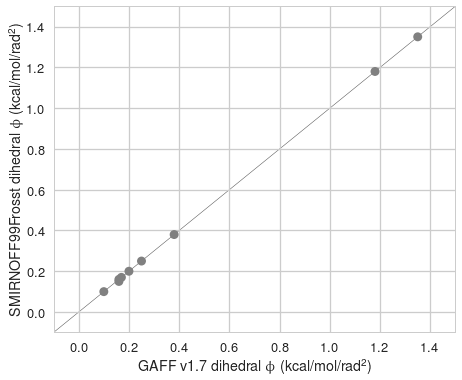

In [99]:
scatter_dihedral(bgbg_smirnoff, "x_k", "y_k", 
                "GAFF v1.7 dihedral $\phi$ (kcal/mol/rad$^2$)", "SMIRNOFF99Frosst dihedral $\phi$ (kcal/mol/rad$^2$)", 
        -0.1, 1.5, "r", "SMIRNOFF99Frosst-vs-GAFF-v1.7-dihedral-phi.pdf", adjust=True)

In [96]:
bgbg_smirnoff.drop_duplicates(subset=["x_k", "y_k"])

,atom1,atom2,atom3,atom4,periodicity,phase,x_k,y_k
0,C1,C2,C3,C4,1.0,0.0,0.2000,0.2000
0,C1,C2,C3,H3,3.0,0.0,0.1556,0.1600
0,C1,C2,C3,O3,3.0,0.0,0.1556,0.1560
0,C1,C2,O2,HO2,1.0,0.0,0.2500,0.2500
0,C1,O5,C5,C4,2.0,0.0,0.1000,0.1000
0,C1,O5,C5,H5,3.0,0.0,0.3833,0.3833
0,H1,C1,C2,H2,3.0,0.0,0.1556,0.1500
0,H1,C1,C2,O2,3.0,0.0,0.1556,0.2500
0,H2,C2,O2,HO2,3.0,0.0,0.1667,0.1667
0,O1,C1,C2,O2,2.0,0.0,1.1750,1.1750


['C1-C2-C3-C4', 'C2-C3-C4-C5', 'C3-C4-C5-C6']
['C1-C2-C3-H3', 'C2-C3-C4-H4', 'C3-C2-C1-O5', 'C3-C4-C5-H5', 'C3-C4-C5-O5', 'C4-C5-C6-H61', 'C4-C5-C6-H62', 'H1-C1-C2-C3', 'H2-C2-C3-C4', 'H3-C3-C4-C5', 'H4-C4-C5-C6', 'O1-C1-C2-C3', 'O1-C4-C3-C2', 'O1-C4-C5-C6']
['C1-C2-C3-O3', 'C4-C5-C6-O6', 'O2-C2-C3-C4', 'O3-C3-C4-C5']
['C1-C2-O2-HO2', 'C2-C3-O3-HO3', 'C5-C6-O6-HO6', 'HO2-O2-C2-C3', 'HO3-O3-C3-C4']
['C1-O5-C5-C4', 'C1-O5-C5-C6', 'C2-C1-O5-C5', 'C2-C1-O1-C4', 'C1-O1-C4-C3', 'C1-O1-C4-C5']
['C1-O5-C5-H5', 'C1-O1-C4-H4']
['H1-C1-C2-H2', 'H2-C2-C3-H3', 'H3-C3-C4-H4', 'H4-C4-C5-H5', 'H5-C5-C6-H61', 'H5-C5-C6-H62']
['H1-C1-C2-O2']
['H1-C1-O5-C5', 'H1-C1-O1-C4']
['H2-C2-C1-O5', 'H2-C2-C3-O3', 'H4-C4-C5-O5', 'H5-C5-C6-O6', 'O1-C1-C2-H2', 'O2-C2-C3-H3', 'O3-C3-C4-H4', 'O5-C5-C6-H61', 'O5-C5-C6-H62', 'O1-C4-C3-H3', 'O1-C4-C5-H5']
['H2-C2-O2-HO2', 'H3-C3-O3-HO3', 'H61-C6-O6-HO6', 'H62-C6-O6-HO6']
['O1-C1-C2-O2', 'O2-C2-C1-O5', 'O5-C5-C6-O6', 'O1-C4-C3-O3']
['O1-C1-O5-C5', 'O5-C1-O1-C4']
['O2-C2-C3

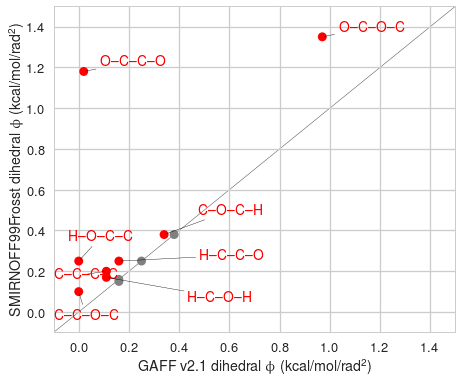

In [98]:
scatter_dihedral(bg2bg2_smirnoff, "x_k", "y_k", 
                "GAFF v2.1 dihedral $\phi$ (kcal/mol/rad$^2$)", "SMIRNOFF99Frosst dihedral $\phi$ (kcal/mol/rad$^2$)", 
        -0.1, 1.5, "r", "SMIRNOFF99Frosst-vs-GAFF-v2.1-dihedral-phi.pdf", adjust=True)

In [68]:
bg2bg2_smirnoff[bg2bg2_smirnoff.atom1.str.contains("H") &
               bg2bg2_smirnoff.atom2.str.contains("O") &
               bg2bg2_smirnoff.atom3.str.contains("C") &
               bg2bg2_smirnoff.atom4.str.contains("C")]

,atom1,atom2,atom3,atom4,periodicity,phase,x_k,y_k
0,HO2,O2,C2,C3,3.0,0.0,0.0,0.25
0,HO3,O3,C3,C4,3.0,0.0,0.0,0.25


In [70]:
bg2bg2_prmtop

<AmberParm 146 atoms; 10 residues; 148 bonds; parametrized>

In [72]:
pmd.tools.actions.printDihedrals(bg2bg2_prmtop, ":4@HO2 :4@O2 :4@C2 :4@C3")

               Atom 1               Atom 2               Atom 3               Atom 4     Height  Periodic.      Phase  EEL Scale  VDW Scale
       10  HO2 (  ho)        9   O2 (  oh)        7   C2 (  c3)       11   C3 (  c3)     0.0000     3.0000     0.0000     1.2000     2.0000

In [74]:
pmd.tools.actions.printDihedrals(bg2bg2_prmtop, ":4@HO2 :4@O3 :4@C2 :4@C4")

               Atom 1               Atom 2               Atom 3               Atom 4     Height  Periodic.      Phase  EEL Scale  VDW Scale